## 1. Výpočet tepové frekvence z EKG signálu
Zadání: Ve zdrojové databázi najdete celkem 18 měření EKG signálu pro různé věkové skupiny. Signál
obsahuje různé anomálie a nemusí být vždy centralizován podle vodorovné osy. EKG signál
obsahuje dominantní peaky, které se nazývají R vrcholy. Vzdálenost těchto vrcholů určuje dobu
mezi jednotlivými tepy. Počet tepů za minutu je tedy počet R vrcholů v signálu o délce jedné
minuty. Navrhněte algoritmus, který bude automaticky detekovat počet R vrcholů v EKG
signálech a prezentujte tepovou frekvenci při jednotlivých jízdách/měřeních. Vás algoritmus
následně otestujte na databázi MIT-BIH https://physionet.org/content/nsrdb/1.0.0/ a
prezentujte jeho úspěšnost vzhledem k anotovaným datům z databáze.

In [4]:
import pandas as pd
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import *
import os


In [5]:
def extract_ecg_metadata(record_name: str) -> pd.DataFrame:
    """
    Načte záznam EKG a extrahuje metadata.
    """
    # Načtení dat
    record = wfdb.rdrecord(record_name)
    
    # Vytvoření tabulky s metadaty
    data = [
        ["Název souboru", record.record_name],  # Název souboru
        ["Vzorkovací frekvence (Hz)", record.fs],  # Vzorkovací frekvence
        ["Délka signálu (vzorky)", record.sig_len],  # Délka signálu (počet vzorků)
        ["Počet kanálů", record.n_sig],  # Počet kanálů
        ["Názvy kanálů", ", ".join(record.sig_name)],  # Názvy kanálů
        ["Jednotky", "uV"],  # Jednotky měření (uV pro EKG)
        ["ADC Gain", record.adc_gain[0] if record.adc_gain is not None else "N/A"],  # Zesilovací koeficient
        ["Baseline (posun)", record.baseline[0] if record.baseline is not None else "N/A"]  # Posun základní linie
    ]
    
    # Vytvoření DataFrame
    df = pd.DataFrame(data, columns=["Informace", "Hodnota"])
    
    return df


def signal(record_name: str):
    """
    Funkce vrací EKG signál jako numpy pole.
    """
    record = wfdb.rdrecord(record_name)
    ecg_signal = record.p_signal[:, 0]  # První kanál signálu
    fs = record.fs  # Vzorkovací frekvence
    return ecg_signal, fs  


def center_signal(ecg_signal):
    """
    Centrovaní signálu - odstranění střední hodnoty.
    """
    return ecg_signal - np.mean(ecg_signal)


def plot_ecg_signal(signal, sampfrom: int = 0, sampto: int = None):
    """
    Vykreslí signál EKG z daného záznamu.
    """

    if sampfrom is None:
        sampfrom = 0
    if sampto is None:
        sampto = len(ecg_signal) 

    # Vykreslení signálu
    plt.figure(figsize=(18, 5))
    plt.plot(signal[sampfrom:sampto])
    plt.title("EKG signál")
    plt.xlabel("Čas (vzorky)")
    plt.ylabel("Amplituda")
    plt.show()


def bandpass_filter(signal, fs, lowcut=5, highcut=15, order=2):
    """
    Pásmová propust Butterworthova filtru.
    """
    nyquist = 0.5 * fs  # Nyquistova frekvence
    low = lowcut / nyquist
    high = highcut / nyquist

    # Vytvoření koeficientů Butterworthova filtru
    b, a = butter(order, [low, high], btype='band')

    # Dvojnásobná filtrace pro minimalizaci fázového zkreslení
    filtered_signal = filtfilt(b, a, signal)

    return filtered_signal


def derivative_filter(signal):
    """
    y(n)= 1/8* [-x(n-2)-2x(n-1)+2x(n+1)+x(n+2)]
    """ 
    kernel = np.array([-1, -2, 0, -2, -1])
    return np.convolve(signal, kernel, mode='same')


def square_filter(signal):
  return np.square(signal) 


def moving_window_integration(signal, fs):
    """
    Aplikuje klouzavý průměr na signál.
    """
    window_size=150
    n = int(window_size * fs / 1000 )                     # Převod milisekund na počet vzorků
    window = np.ones(n) / n                               # Vytvoření vyhlazovacího okna
    return np.convolve(signal, window, mode='same') 


def detect_r_peaks(signal, fs):
    rr_interval = 400
    
    distance = int(rr_interval*fs/1000)
    height = height = np.median(signal) + 0.3 * np.std(signal)

    peaks, _ = find_peaks(signal, height=height, distance=distance)
    return peaks


def plot_r_peaks(ecg_signal, r_peaks, sampfrom=0, sampto=None):
    """
    Vizualizace EKG signálu s označenými R-píky.
    """
    if sampto is None:
        sampto = len(ecg_signal)
    
    plt.figure(figsize=(18, 5))
    plt.plot(ecg_signal[sampfrom:sampto], label='EKG signál')
    plt.scatter(r_peaks[(r_peaks >= sampfrom) & (r_peaks < sampto)] - sampfrom, 
                ecg_signal[r_peaks[(r_peaks >= sampfrom) & (r_peaks < sampto)]], 
                color='red', label='R-píky', marker='o')
    plt.title('Detekce R-píků na EKG signálu')
    plt.xlabel('Čas (vzorky)')
    plt.ylabel('Amplituda')
    plt.legend()
    plt.show()


def calculate_bpm(r_peaks, fs):
    """
    Vypočítá průměrnou srdeční frekvenci (BPM) na základě detekovaných R-vrcholů.
    """
    rr_intervals = np.diff(r_peaks) / fs                                                     # Převod na sekundy

    mean_rr = np.mean(rr_intervals)

    bpm = 60 / mean_rr                                                                         # průměrný RR interval (v sekundách)

    return bpm



def get_annotated_r_peaks(record_name: str):
    """
    Získává anotované R-píky z anotací PhysioNet.
    """
    annotation = wfdb.rdann(record_name, 'atr')  # Načtení anotací
    r_peaks = annotation.sample  # Extrakce indexů R-píků
    return r_peaks




def plot_bpm(r_peaks, fs):
    """
    Vykreslí graf změny srdeční frekvence (BPM) v čase na základě detekovaných R-vrcholů.

    Parametry:
    r_peaks (np.ndarray): Indexy R-vrcholů v signálu.
    fs (int): Vzorkovací frekvence (Hz).
    """

    if len(r_peaks) < 2:
        print("Nedostatečný počet R-vrcholů pro výpočet BPM.")
        return

    rr_intervals = np.diff(r_peaks) / fs  

    bpm_values = 60 / rr_intervals

    # Vytvoření časové osy pro BPM (střed RR intervalu v sekundách)
    time_axis = r_peaks[1:] / fs  

    # Vykreslení grafu
    plt.figure(figsize=(18, 5))
    plt.plot(time_axis, bpm_values,  label='BPM')
    plt.xlabel("Čas (sekundy)")
    plt.ylabel("Srdeční frekvence (BPM)")
    plt.title("Změna BPM v čase")
    plt.grid(True)
    plt.legend()
    plt.show()




def plot_bpm_first_10_minutes(r_peaks, fs):
    """
    Vykreslí graf změny srdeční frekvence (BPM) za prvních 10 minut záznamu.
    """

    if len(r_peaks) < 2:
        print("Nedostatečný počet R-vrcholů pro výpočet BPM.")
        return

    rr_intervals = np.diff(r_peaks) / fs  
    bpm_values = 60 / rr_intervals
    time_axis = r_peaks[1:] / fs  

    # Filtrace na prvních 10 minut (600 sekund)
    sampfrom = 0
    sampto = 600 

    mask = (time_axis >= sampfrom) & (time_axis <= sampto)
    time_filtered = time_axis[mask]
    bpm_filtered = bpm_values[mask]

    # Kontrola, zda po filtrování existují data
    if len(time_filtered) == 0 or len(bpm_filtered) == 0:
        print("Chyba: Po filtrování nezůstaly žádné body k vykreslení.")
        return

    
    plt.figure(figsize=(18, 5))
    plt.plot(time_filtered, bpm_filtered, label='BPM')
    plt.xlabel("Čas (sekundy)")
    plt.ylabel("Srdeční frekvence (BPM)")
    plt.title(f"Změna BPM během prvních 10 minut záznamu")
    plt.grid(True)
    plt.legend()
    plt.show()



In [4]:
record_name = "100001/100001_ECG"

ecg_signal, fs = signal(record_name)


In [5]:
# Vypsání informací o signálu
metadata_df = extract_ecg_metadata(record_name)

print(metadata_df)

                   Informace     Hodnota
0              Název souboru  100001_ECG
1  Vzorkovací frekvence (Hz)        1000
2     Délka signálu (vzorky)    87087000
3               Počet kanálů           1
4               Názvy kanálů         ECG
5                   Jednotky          uV
6                   ADC Gain       1.996
7           Baseline (posun)      -12200


In [6]:
# Centrovaný signál
centered_signal = center_signal(ecg_signal)

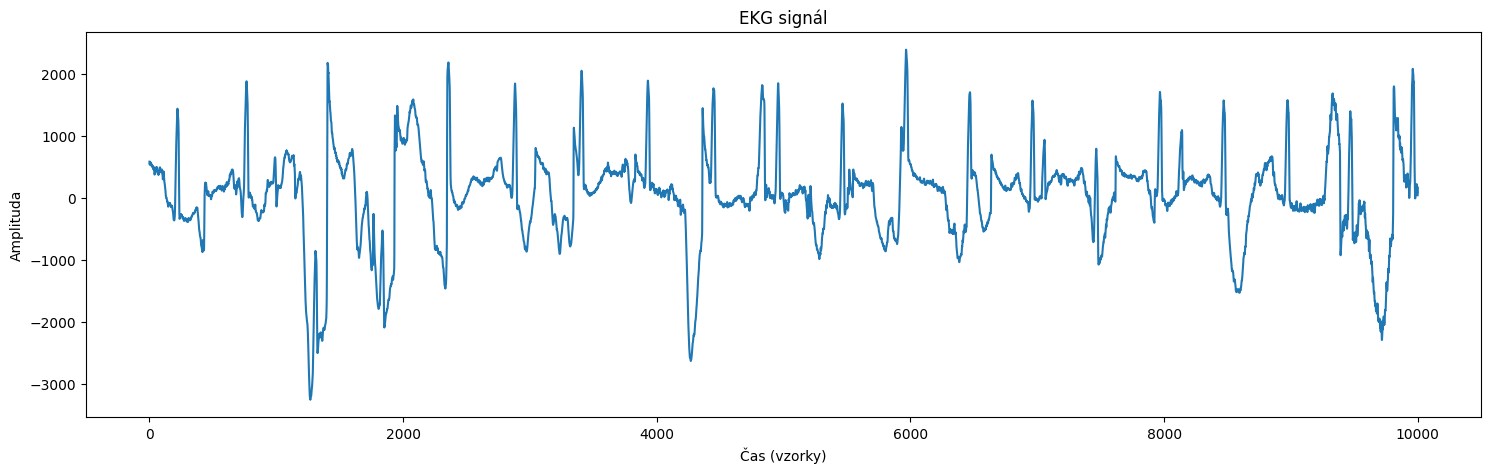

In [7]:
# Vykreslení části signálu 
plot_ecg_signal(ecg_signal, sampfrom=70000, sampto=80000)

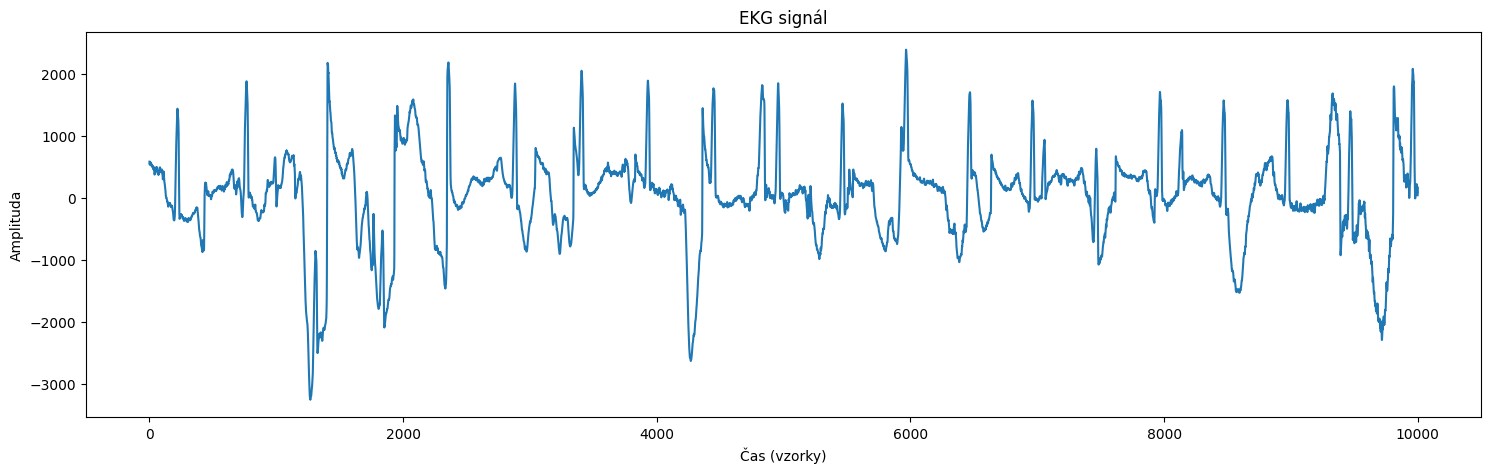

In [8]:
# Vykreslení části centralizovaného signálu  
plot_ecg_signal(centered_signal, sampfrom=70000, sampto=80000)

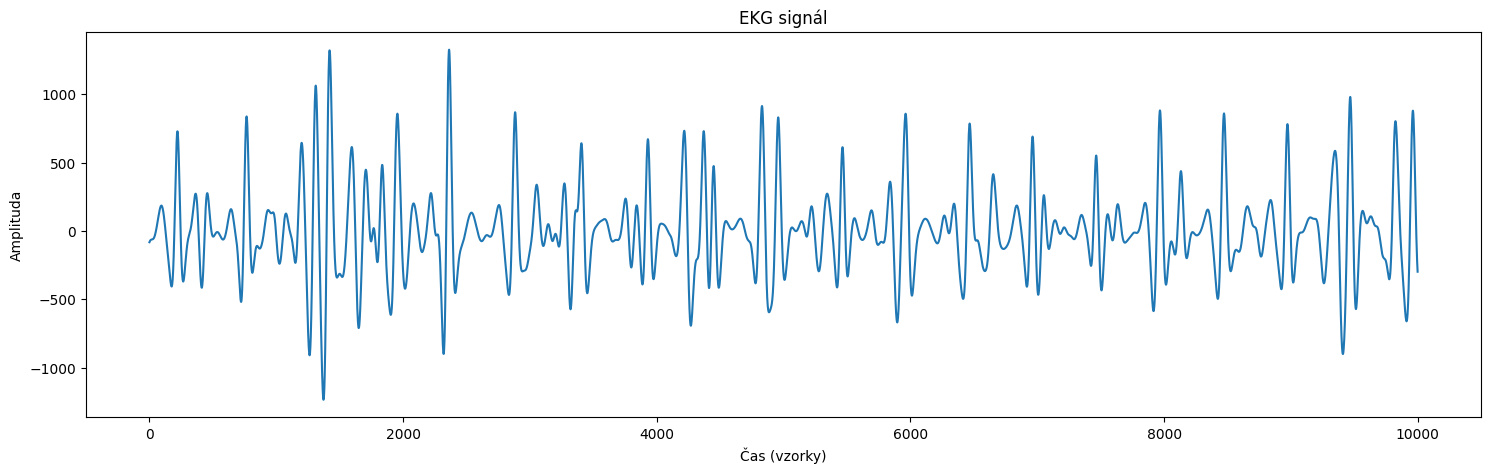

In [9]:
# Signál po filtraci 
bandpass_signal = bandpass_filter(centered_signal, fs)
plot_ecg_signal(bandpass_signal,sampfrom=70000, sampto=80000)

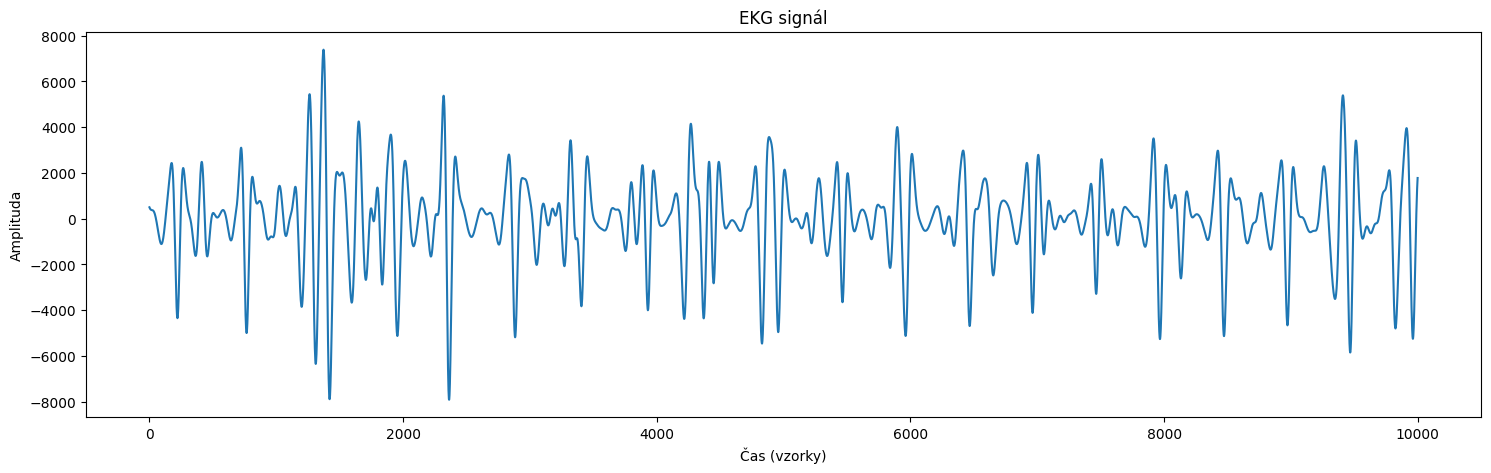

In [10]:
# Signál po derivaci 
derivated_signal = derivative_filter(bandpass_filter(centered_signal, fs))
plot_ecg_signal(derivated_signal, sampfrom=70000, sampto=80000)

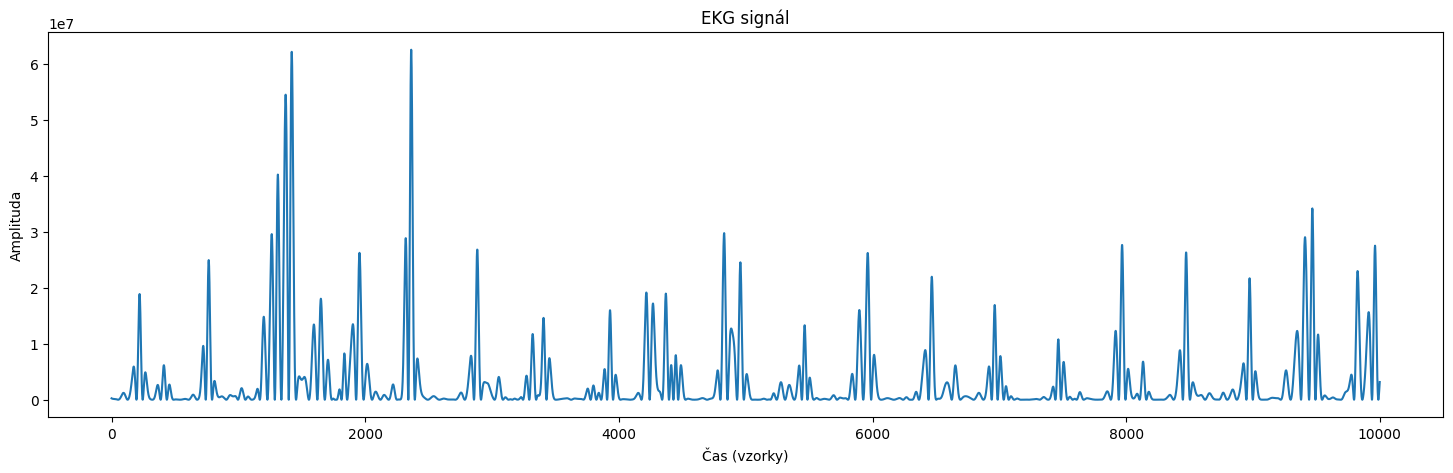

In [11]:
# Signál po umocnění na druhou 
squared_signal = square_filter(derivative_filter(bandpass_filter(centered_signal, fs)))
plot_ecg_signal(squared_signal, sampfrom=70000, sampto=80000)

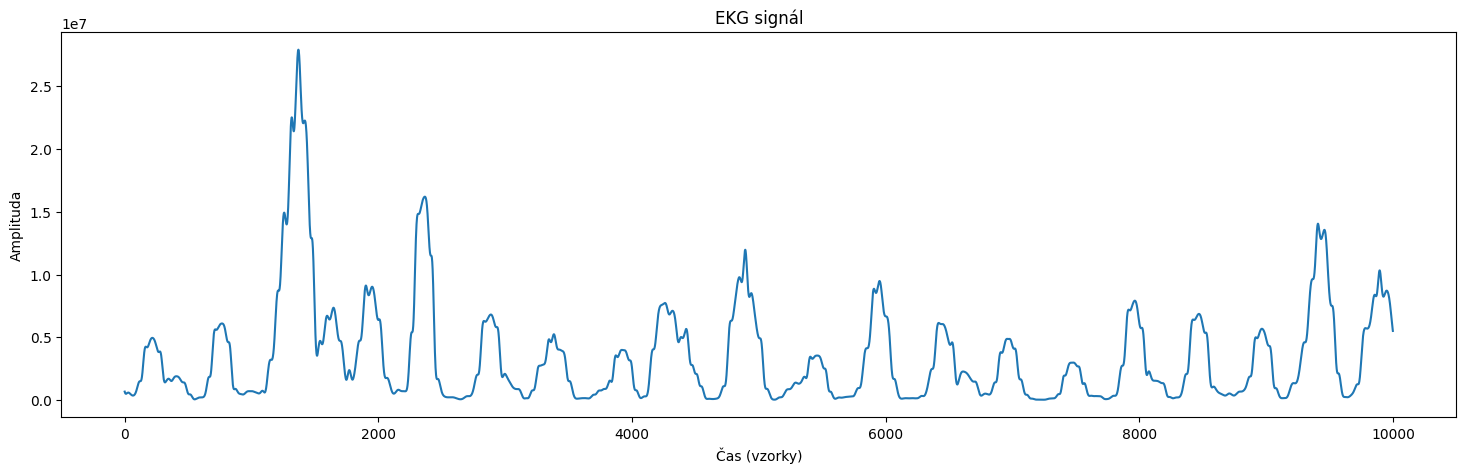

In [12]:
# Signál po vyhlazení (integrální posuvné okno)
smoothed_signal = moving_window_integration(squared_signal, fs)
plot_ecg_signal(smoothed_signal, sampfrom=70000, sampto=80000)

In [13]:
# počet R-vrcholů na celém signálu 
r_peaks = detect_r_peaks(smoothed_signal, fs)
print(r_peaks)
print(len(r_peaks))


[     306      848     1386 ... 87085086 87085905 87086756]
117161


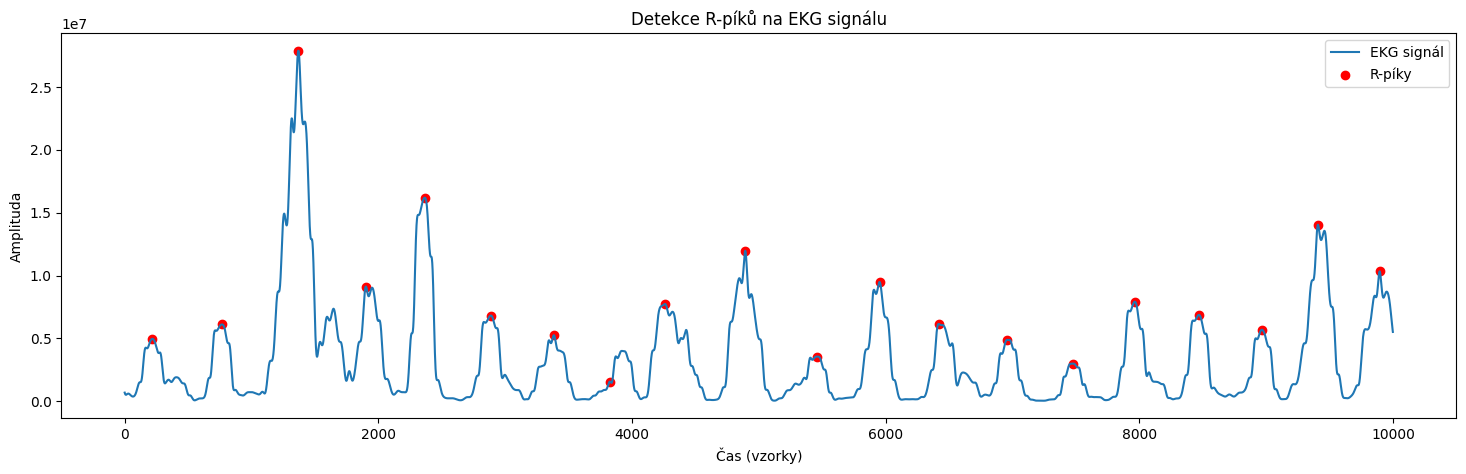

In [14]:
plot_r_peaks(smoothed_signal, r_peaks,sampfrom=70000, sampto=80000 )

In [16]:
# Průměrné BPM
bpm = calculate_bpm(r_peaks, fs)
print(bpm)

80.71979050701918


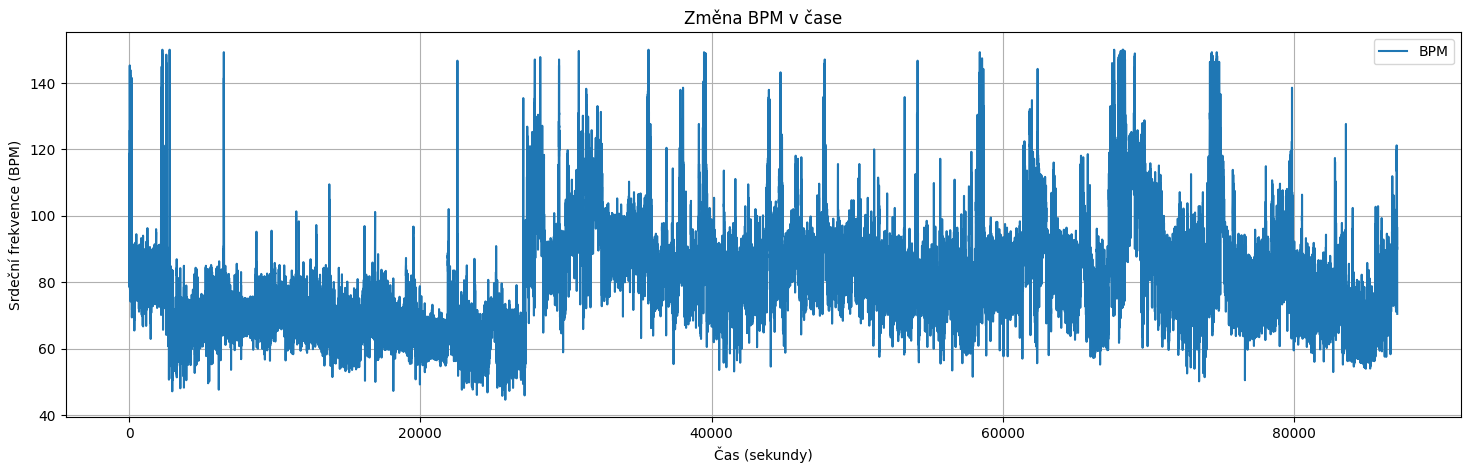

In [17]:
# Graf BPM celého záznamu 
plot_bpm(r_peaks, fs)

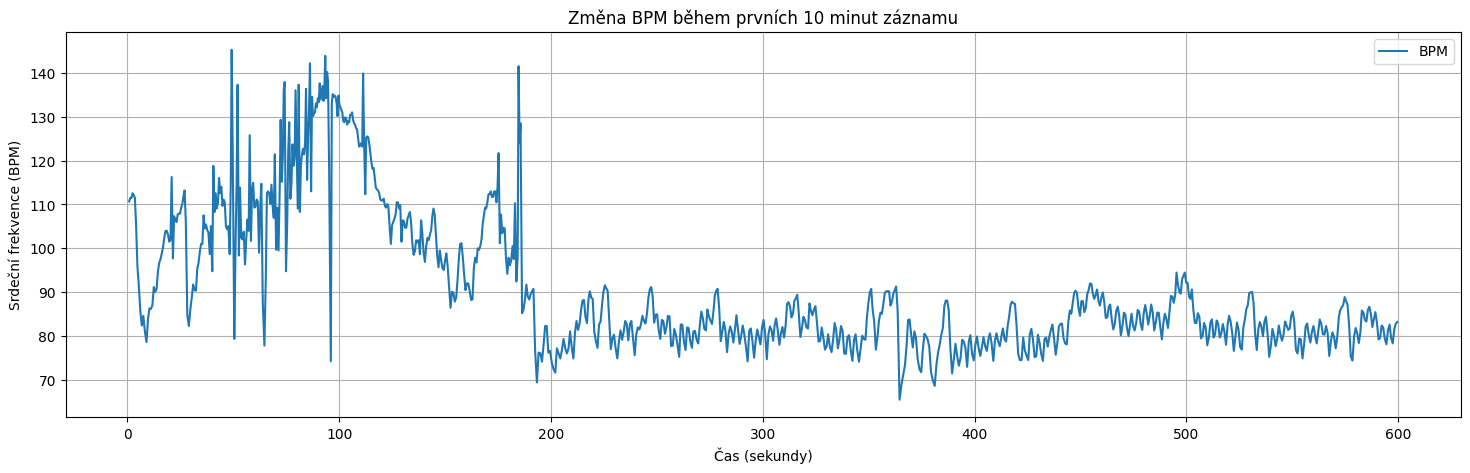

In [20]:
# Graf BPM za prvních 10 minut
plot_bpm_first_10_minutes(r_peaks, fs)


In [6]:
def full_function_for_detection_r_peaks(record_path):
    """
    Zpracuje EKG signál a detekuje R-vrcholy pomocí několika filtrací a analýz signálu.
    """

    ecg_signal, fs = signal(record_path)
    centered_signal = center_signal(ecg_signal)
    bandpass_signal = bandpass_filter(centered_signal, fs)
    derivated_signal = derivative_filter(bandpass_signal)
    squared_signal = square_filter(derivated_signal)
    smoothed_signal = moving_window_integration(squared_signal, fs)

    r_peaks = detect_r_peaks(smoothed_signal, fs)

    return r_peaks
    

def evaluate_detection(directory):
    """
    Vyhodnotí detekci R-vrcholů pro dané záznamy a vytvoří tabulku úspěšnosti.
    """
    results = []

    for filename in os.listdir(directory):
        if filename.endswith(".dat"): 
            record_name = filename.replace(".dat", "")  # Odebereme příponu
            record_path = os.path.join(directory, record_name)  # Použití úplné cesty

            try:
                # Ověření, zda soubory existují
                if not os.path.exists(f"{record_path}.hea") or not os.path.exists(f"{record_path}.dat"):
                    print(f"Soubor {record_path}.hea nebo {record_path}.dat nebyl nalezen, přeskočeno.")
                    continue

                # Načtení signálu a anotací
                record = wfdb.rdrecord(record_path)
                annotation = wfdb.rdann(record_path, 'atr')

                # Detekce R-vrcholů
                detected_r_peaks = full_function_for_detection_r_peaks(record_path)

                # Skutečné R-vrcholy (z anotací)
                true_r_peaks = annotation.sample

                # Výpočet správně detekovaných a chybných R-vrcholů
                correct = np.sum(np.isin(detected_r_peaks, true_r_peaks))
                wrong = len(detected_r_peaks) - correct
                total = len(detected_r_peaks)
                success_rate = (correct / total) * 100 if total > 0 else 0

                results.append([record_name, correct, wrong, total, success_rate])

            except Exception as e:
                print(f"Chyba při zpracování {record_name}: {e}")

    # Vytvoření tabulky s výsledky
    df_results = pd.DataFrame(results, columns=["File", "Correct", "Wrong", "Total", "Success rate"])

    return df_results


In [18]:
# Detekce R-vrcholu s přesným porovnáváním indexů 
directory = "test"
df_results = evaluate_detection(directory)

print(df_results)


     File  Correct   Wrong   Total  Success rate
0   16795    41760   45142   86902     48.054130
1   16420    33409   68677  102086     32.726329
2   19088    14414   85234   99648     14.464917
3   16786        0  101632  101632      0.000000
4   18184      166  102328  102494      0.161961
5   16483    12286   92050  104336     11.775418
6   19830    39645   70608  110253     35.958205
7   16265      114  100366  100480      0.113455
8   16272    36655   45704   82359     44.506368
9   19140     2055   94759   96814      2.122627
10  16273      107   89735   89842      0.119098
11  16539    80746   27536  108282     74.570104
12  17052     1965   85592   87557      2.244252
13  18177    29649   86547  116196     25.516369
14  19090    19353   62260   81613     23.713134
15  17453    57817   42855  100672     57.431063
16  19093    43637   31602   75239     57.997847
17  16773     1273   80714   81987      1.552685


# 2. Detekce anomálií v signálech
Zadání: Ve zdrojové databázi najdete celkem 18 měření EKG obsahující úplné (3 signály) nebo částečné
anotace událostí (P,T vlny a QRS komplex). Záznamy EKg obsahují i části, které jsou porušeny
vlivem anomálií (vnější rušení, manipulace s pacientem apod.). Navrhněte způsob, jak
detekovat tyto úseky a prezentujte statistiku výskytu úseků v měřeních.

In [21]:
# Vypsání informací o signálu (ECG.hea)
record_name = "100001/100001_ECG"
extract_ecg_metadata(record_name)

,Informace,Hodnota
0,Název souboru,100001_ECG
1,Vzorkovací frekvence (Hz),1000
2,Délka signálu (vzorky),87087000
3,Počet kanálů,1
4,Názvy kanálů,ECG
5,Jednotky,uV
6,ADC Gain,1.996
7,Baseline (posun),-12200


In [22]:
# Vypsání informací o signálu (ACC.hea)
record_name = "100001/100001_ACC"
extract_ecg_metadata(record_name)

,Informace,Hodnota
0,Název souboru,100001_ACC
1,Vzorkovací frekvence (Hz),100
2,Délka signálu (vzorky),8708700
3,Počet kanálů,3
4,Názvy kanálů,"ACCx, ACCy, ACCz"
5,Jednotky,uV
6,ADC Gain,17.6975
7,Baseline (posun),-13052


In [23]:
ann_csv_path = "100001/100001_ANN.csv"
annotations = pd.read_csv(ann_csv_path)

print(annotations.head())


print("\nInformace o souboru:")
print(annotations.info())

           1     198867    2       1.1     19525  1.2    1.3   7047  2.1  \
0   198868.0   320282.0  1.0   19526.0   28694.0  2.0   7048  17209    1   
1   320283.0   373109.0  2.0   28695.0   32739.0  1.0  17210  28390    2   
2   373110.0  2197974.0  1.0   32740.0   96699.0  2.0  28391  32653    1   
3  2197975.0  2582746.0  2.0   96700.0  110564.0  1.0  32654  71061    2   
4  2582747.0  2782616.0  1.0  110565.0  112474.0  2.0  71062  72663    3   

        1.4    7047.1  2.2  
0    7048.0   17209.0  1.0  
1   17210.0   28694.0  2.0  
2   28695.0   32653.0  1.0  
3   32654.0  112474.0  2.0  
4  112475.0  174872.0  1.0  

Informace o souboru:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       200 non-null    float64
 1   198867  200 non-null    float64
 2   2       200 non-null    float64
 3   1.1     310 non-null    float64
 4   19525   310 n

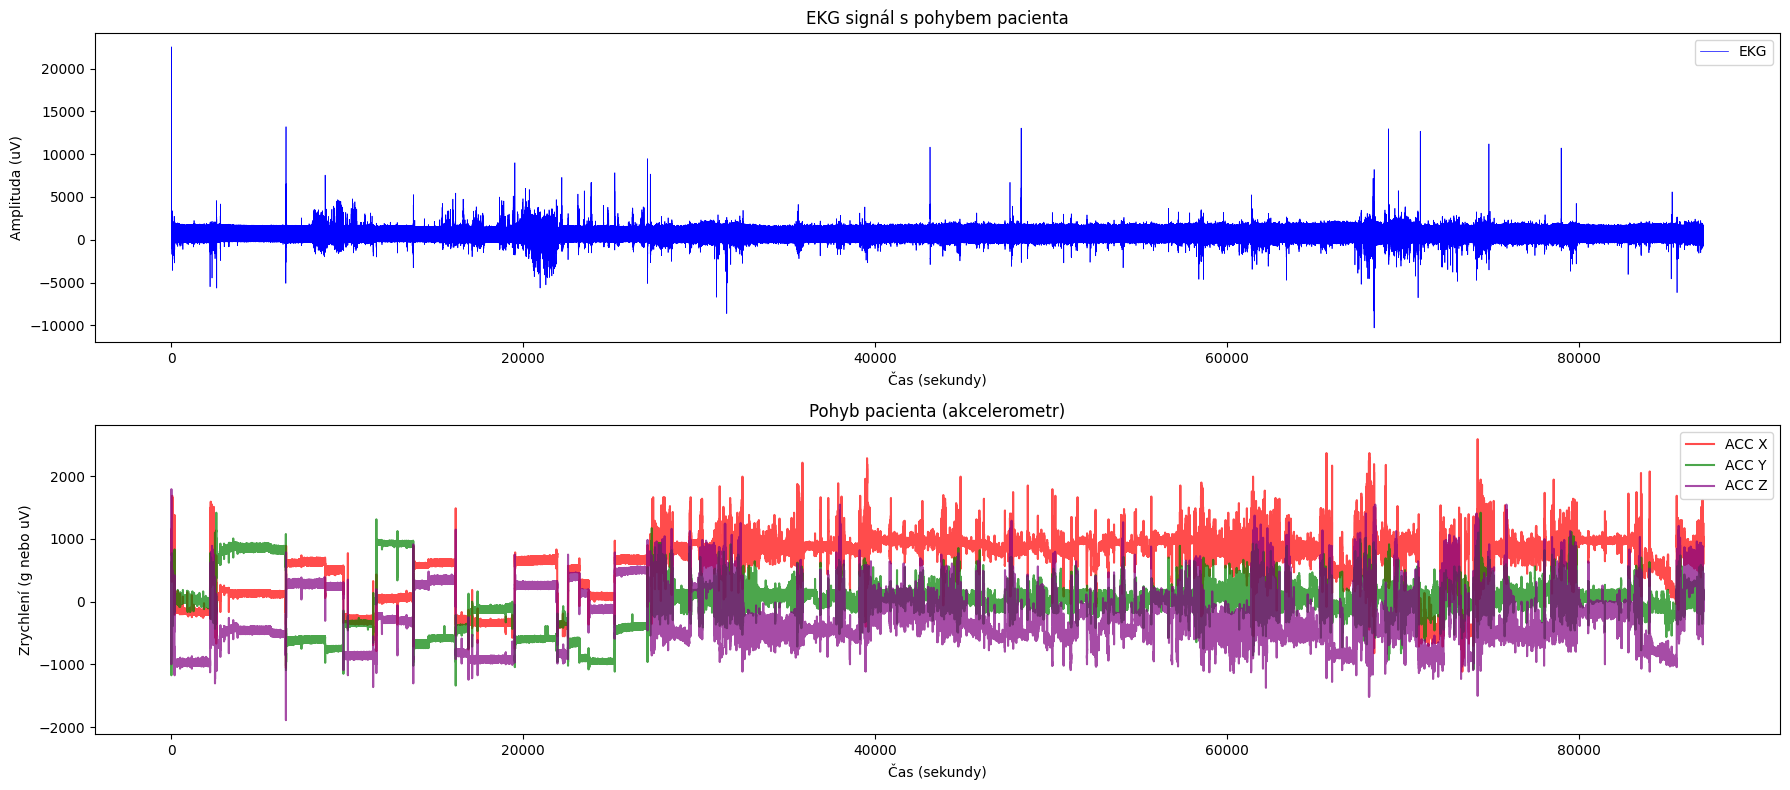

In [26]:
record_name_ecg = "100001/100001_ECG"
ecg_signal, fs = signal(record_name_ecg)

record_name_acc = "100001/100001_ACC"
record_acc = wfdb.rdrecord(record_name_acc)
acc_x = record_acc.p_signal[:, 0]  
acc_y = record_acc.p_signal[:, 1]  
acc_z = record_acc.p_signal[:, 2] 
fs_acc = record_acc.fs  

# Vytvoření časové osy (v sekundách)
time_ecg = np.arange(len(ecg_signal)) / fs  # EKG
time_acc = np.arange(len(acc_x)) / fs_acc  # Akcelerometr

# Vykreslení grafů EKG a pohybu pacienta
plt.figure(figsize=(18, 8))

# Graf EKG signálu
plt.subplot(2, 1, 1)
plt.plot(time_ecg, ecg_signal, label="EKG", color="blue", linewidth=0.5)
plt.title("EKG signál s pohybem pacienta")
plt.xlabel("Čas (sekundy)")
plt.ylabel("Amplituda (uV)")
plt.legend()

# Graf pohybu pacienta (akcelerometr)
plt.subplot(2, 1, 2)
plt.plot(time_acc, acc_x, label="ACC X", color="red", alpha=0.7)
plt.plot(time_acc, acc_y, label="ACC Y", color="green", alpha=0.7)
plt.plot(time_acc, acc_z, label="ACC Z", color="purple", alpha=0.7)
plt.title("Pohyb pacienta (akcelerometr)")
plt.xlabel("Čas (sekundy)")
plt.ylabel("Zrychlení (g nebo uV)")
plt.legend()

plt.tight_layout()
plt.show()



In [7]:
def calculate_statistics(signal: np.ndarray):
    """
    Vypočítá průměrnou hodnotu a standardní odchylku signálu.
    """
    mean_value = np.mean(signal)  
    std_value = np.std(signal)  
    return mean_value, std_value  


def calculate_thresholds(mean_value, std_value, threshold):
    """
    Vypočítá horní a dolní práh.
    """
    upper_threshold = mean_value + threshold * std_value  # Horní práh
    lower_threshold = mean_value - threshold * std_value  # Dolní práh
    return upper_threshold, lower_threshold


def calculate_thresholds_with_mad(signal, threshold):

    mad_value = np.median(np.abs(signal - np.median(signal)))
    upper_threshold = np.median(signal) + threshold * mad_value
    lower_threshold = np.median(signal) - threshold * mad_value
    return upper_threshold, lower_threshold


def detect_anomalies(signal, upper_threshold, lower_threshold):
    """
    Detekuje anomálie v signálu na základě horního a dolního prahu.
    """
    anomaly_indices = np.where((signal > upper_threshold) | (signal < lower_threshold))[0]
    return anomaly_indices


def plot_signal_with_anomalies(signal, anomaly_indices, upper_threshold, lower_threshold, title="Detekce Anomálií v EKG Signálu"):
    """
    Vykreslí celý EKG signál s detekovanými anomáliemi.
    """
    plt.figure(figsize=(18, 5))

    # Kreslení signálu s tenkou čárou pro lepší čitelnost
    plt.plot(signal, color='royalblue', linewidth=0.5, label="EKG Signál")

    # Kreslení anomálií jako červené tečky
    plt.scatter(anomaly_indices, signal[anomaly_indices], color='red', s=10, label="Detekované Anomálie")

    # Kreslení prahových hodnot (horní a dolní)
    plt.axhline(upper_threshold, color='green', linestyle="--", linewidth=1, label="Horní práh (μ + 3σ)")
    plt.axhline(lower_threshold, color='green', linestyle="--", linewidth=1, label="Dolní práh (μ - 3σ)")

    # Nastavení os a popisů
    plt.xlabel("Vzorky")
    plt.ylabel("Amplituda (μV)")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", linewidth=0.3, alpha=0.5)  # Jemná mřížka pro lepší vizualizaci

    # Zobrazení grafu
    plt.show()



def annotated_anomalies(annotation_file: str):
    """
    Počítá počet anomálií na základě anotací.
    """
    # Načtení anotací
    annotations = pd.read_csv(annotation_file, header=None)
    anomalies_in_annotations = annotations[annotations[2] != 1]

    return anomalies_in_annotations



def compute_detection_metrics(anomalies_in_annotations, detected_anomalies):
    """
    Vypočítá metriky detekce anomálií a vrátí DataFrame s výsledky.
    """
    # Počet anotovaných anomálií (z anotací)
    count_of_annotated_anomalies = len(anomalies_in_annotations)

    # Počet detekovaných anomálií
    count_of_detected_anomalies = len(detected_anomalies)

    # Převod detekovaných anomálií na numpy array pro rychlejší porovnání
    detected_anomalies = np.array(detected_anomalies)

    # Převod intervalů na numpy array
    annotation_starts = anomalies_in_annotations[0].values
    annotation_ends = anomalies_in_annotations[1].values

    # Množina unikátních shodných ANOTACÍ (počítáme уникальные интервалЫ, не отдельные точки)
    matched_annotation_intervals = set()

    # Vektorová operace: najdeme, které anomálie spadají do intervalu
    for i, (start, end) in enumerate(zip(annotation_starts, annotation_ends)):
        in_interval = (detected_anomalies >= start) & (detected_anomalies <= end)
        if np.any(in_interval):  # Pokud existuje alespoň jedna detekovaná anomálie v intervalu
            matched_annotation_intervals.add(i)  # Přidáme index anotace (unikátní interval)

    # Počet shodných anotací (unikátní intervaly)
    total_annotations = len(matched_annotation_intervals)

    # Výpočet úspěšnosti detekce (%)
    detection_accuracy = (total_annotations / count_of_annotated_anomalies) * 100 if count_of_annotated_anomalies > 0 else 0.0

    # Vytvoření tabulky s výsledky
    data = [
        ["Počet anomálií (dle anotací)", count_of_annotated_anomalies],
        ["Počet detekovaných anomálií", count_of_detected_anomalies],
        ["Počet shodných anotací", total_annotations],
        ["Úspěšnost detekce", f"{detection_accuracy:.2f} %"]
    ]

    df = pd.DataFrame(data, columns=["Metrika", "Hodnota"])
    return df



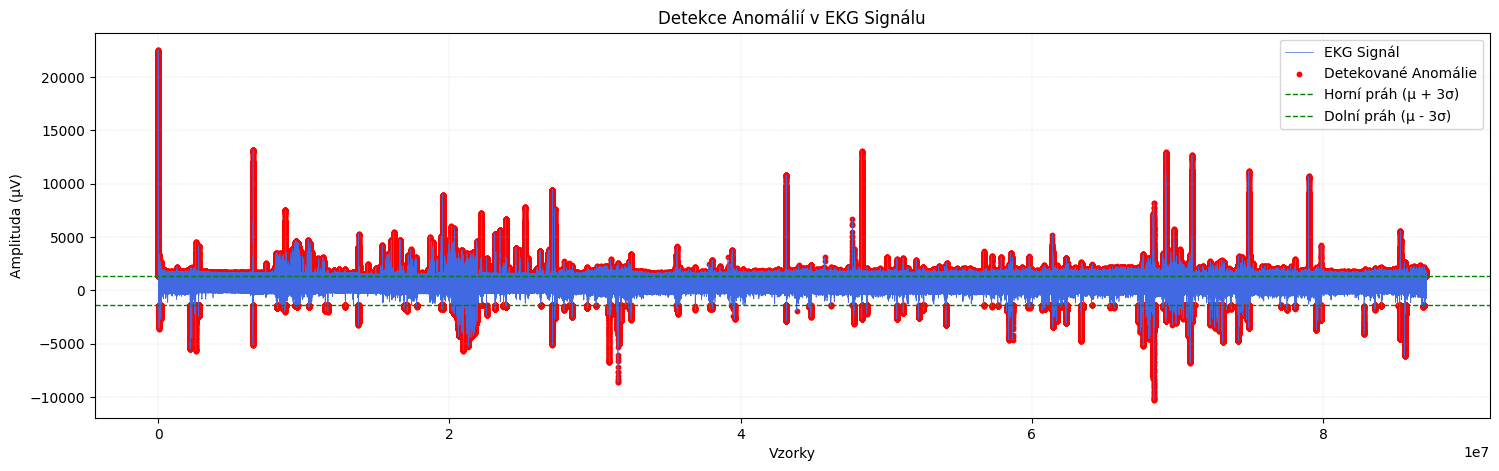

In [28]:
# Cesta k souboru 
record_name = "100001/100001_ECG"

ecg_signal, fs = signal(record_name) # Signál a frekvence 
mean_value, std_value = calculate_statistics(ecg_signal) # Průměrná hodnota a Standardní odchylka

# threshold = 3, Používáme standardní odchylku
upper_threshold, lower_threshold = calculate_thresholds(mean_value, std_value, 3)
anomaly_indices = detect_anomalies(ecg_signal,upper_threshold, lower_threshold)

plot_signal_with_anomalies(ecg_signal, anomaly_indices, upper_threshold, lower_threshold)

In [12]:
ann_csv_path = "100001/100001_ANN.csv"
anomalies_in_annotations = annotated_anomalies(ann_csv_path)
results = compute_detection_metrics(anomalies_in_annotations, anomaly_indices)
results

,Metrika,Hodnota
0,Počet anomálií (dle anotací),1147
1,Počet detekovaných anomálií,2289938
2,Počet shodných anotací,102
3,Úspěšnost detekce,8.89 %


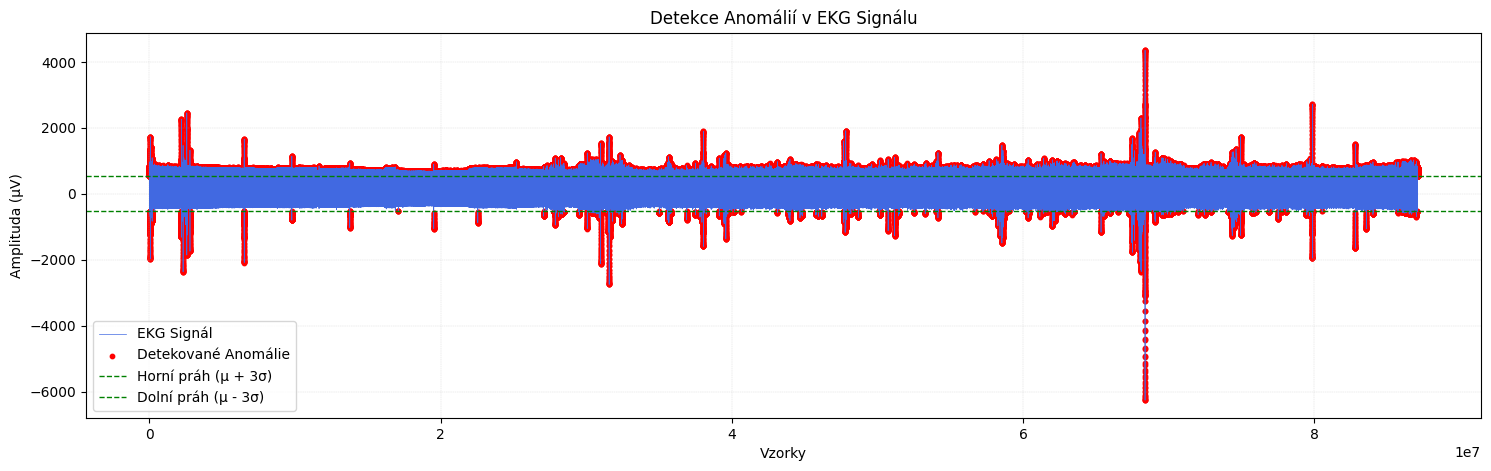

In [29]:
record_path = "100001/100001_ECG"
ecg_signal, fs = signal(record_path)
centered_signal = center_signal(ecg_signal)
bandpass_signal = bandpass_filter(centered_signal, fs)


mean_value, std_value = calculate_statistics(bandpass_signal) 

# threshold = 3, Používáme standardní odchylku
upper_threshold, lower_threshold = calculate_thresholds(mean_value, std_value, 3)
anomaly_indices = detect_anomalies(bandpass_signal,upper_threshold, lower_threshold)

plot_signal_with_anomalies(bandpass_signal, anomaly_indices, upper_threshold, lower_threshold)

In [22]:
ann_csv_path = "100001/100001_ANN.csv"
anomalies_in_annotations = annotated_anomalies(ann_csv_path)
results = compute_detection_metrics(anomalies_in_annotations, anomaly_indices)
results

,Metrika,Hodnota
0,Počet anomálií (dle anotací),1147
1,Počet detekovaných anomálií,2697280
2,Počet shodných anotací,102
3,Úspěšnost detekce,8.89 %


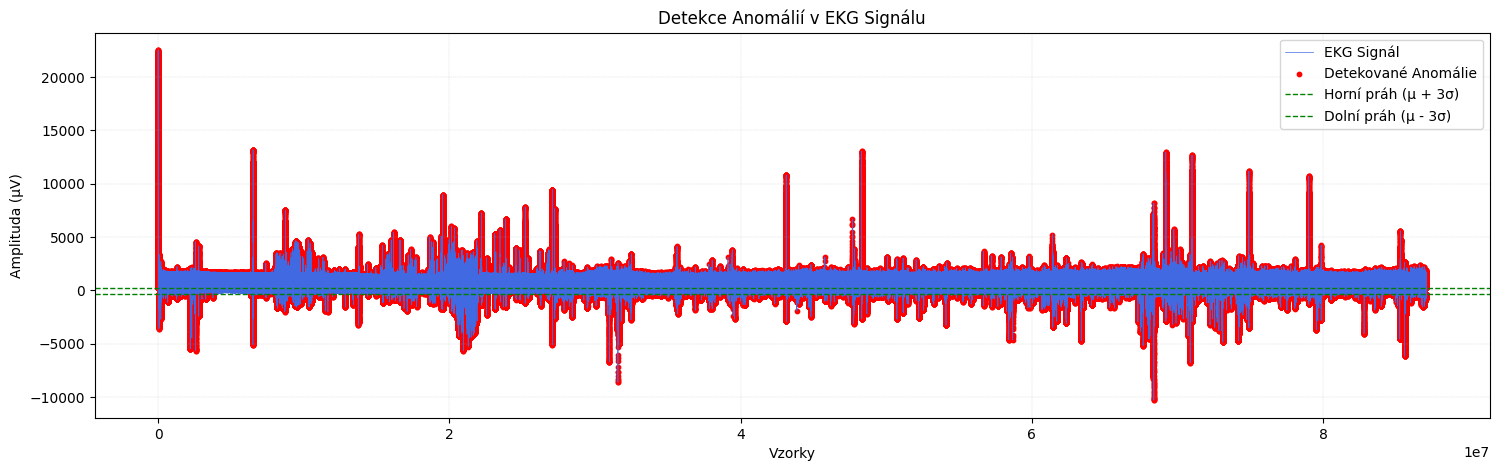

In [8]:
# Cesta k souboru 
record_name = "100001/100001_ECG"

ecg_signal, fs = signal(record_name) # Signál a frekvence 
mean_value, std_value = calculate_statistics(ecg_signal) # Průměrná hodnota a Standardní odchylka

# threshold = 3, Používáme mad 
upper_threshold, lower_threshold = calculate_thresholds_with_mad(ecg_signal, 3)
anomaly_indices = detect_anomalies(ecg_signal,upper_threshold, lower_threshold)

plot_signal_with_anomalies(ecg_signal, anomaly_indices, upper_threshold, lower_threshold)

In [26]:
ann_csv_path = "100001/100001_ANN.csv"
anomalies_in_annotations = annotated_anomalies(ann_csv_path)
results = compute_detection_metrics(anomalies_in_annotations, anomaly_indices)
results

,Metrika,Hodnota
0,Počet anomálií (dle anotací),1147
1,Počet detekovaných anomálií,15332475
2,Počet shodných anotací,102
3,Úspěšnost detekce,8.89 %
